In [4]:
from magpie import grasp as gt
import rtde_control
import rtde_receive
from magpie.motor_code import Motors
from magpie import ur5 as ur5
import time
import numpy as np
import copy
import magpie
from magpie.gripper import Gripper

In [ ]:
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw

In [ ]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [ ]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(pth=path)

In [5]:
import importlib
importlib.reload(gt)
importlib.reload(ur5)
importlib.reload(magpie.gripper)

<module 'magpie.gripper' from '/home/will/MAGPIE/magpie/gripper.py'>

In [ ]:
# load arrays in saved_poses/ folder as array of arrays
saved_poses = []
for i in range(5):
    saved_poses.append(np.load(f'saved_poses/pose_{i+1}.npy', allow_pickle=True))

In [ ]:
# move gripper to cartesian pos
# OR orient gripper in place
name = "pose_5"
sleepRate = 1.5
# time.sleep(sleepRate)
ur = ur5.UR5_Interface()
try:
    ur.start()
    currentPose = ur.getPose()
    print(currentPose)
    # save pose to npy
    for i in saved_poses:
        # print(f"moving to pose {i + 1}: {saved_poses[i]}")
        ur.moveL(i)
        time.sleep(sleepRate)
        time.sleep(sleepRate)
    ur.stop()
except Exception as e:
    ur.stop()
    raise(e)

In [ ]:
def rgbdimg():
    p, rgbd_image = rsc.getPCD()
    image = np.array(rgbd_image.color)
    queries = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
    queries = ["a photo of an blue cylindrical container", "a photo of a small red cubic block", "a photo of a screwdriver handle" ]
    queries = ["a photo of a black student ID card", "a photo of a small orange fruit", "a photo of a small plastic bag"]
    queries = ["a photo of an avocado", "a photo of a small orange fruit", "a photo of a small plastic bag", "a photo of a paper airplane"]
    queries = ["a photo of a water bottle with a red top"]
    queries = ["a photo of a blue block"]
    # queries = ["a photo of a tail"]
    # queries = ["a photo of a black handle of a pair of scissors"]
    abbrevq = ["apple", "lemon", "lime", "pear", "onion"]
    abbrevq = ["blue", "block", "handle"]
    abbrevq = ["card", "orange", "bag"]
    abbrevq = ["avocado", "orange", "bag", "paper airplane"]
    abbrevq = ["block"]
    label_vit.set_threshold(0.005)
    # bboxes, uboxes = label_vit.label(image, queries, abbrevq, topk=True, plot=True)
    bboxes, uboxes = label_vit.label(image, queries, abbrevq, topk=True, plot=True)
    return rgbd_image

In [6]:
# set matrix
# tmat = np.array([[ 0.91574736, -0.35602909,  0.18614527, -0.02848649],
#        [-0.40073104, -0.77640133,  0.48643151,  0.14332736],
#        [ 0.02866033,  0.52004256,  0.85365937,  0.33750796],
#        [ 0.        ,  0.        ,  0.        ,  1.        ]])

tmat = np.array([[ 0.98665647, -0.16180182, -0.01814324,  0.04438557],
       [-0.1565328 , -0.97333117,  0.16770185,  0.04194964],
       [ 0.04479385,  0.1626241 ,  0.98567079,  0.32025074],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

aperture = 37
# z_offset = G.aperture_to_z(aperture)/1000.0

mmc = copy.deepcopy(tmat[:3, 3])
# grasp_pose = [mmc[1], -mmc[0], mmc[2]]
grasp_pose = mmc
tmat[:3, 3] = [0, 0, 0]
homePose = None
z_offset = 100/1000.0
z_offset -= 0.035
z_offset

0.065

In [33]:
# move gripper to cartesian pos
# OR orient gripper in place
name = "pose_5"
sleepRate = 4
# time.sleep(sleepRate)
ur = ur5.UR5_Interface()
try:
    ur.start()
    currentPose = ur.getPose()
    print(currentPose)

    ur.moveL(saved_poses[4])
    time.sleep(sleepRate)
    time.sleep(sleepRate)
    ur.stop()
except Exception as e:
    ur.stop()
    raise(e)

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
  -0.03359  -0.9674   -0.2508   -0.3618    
  -0.9976    0.01721   0.06721  -0.08704   
  -0.0607    0.2525   -0.9657    0.1932    
   0         0         0         1         



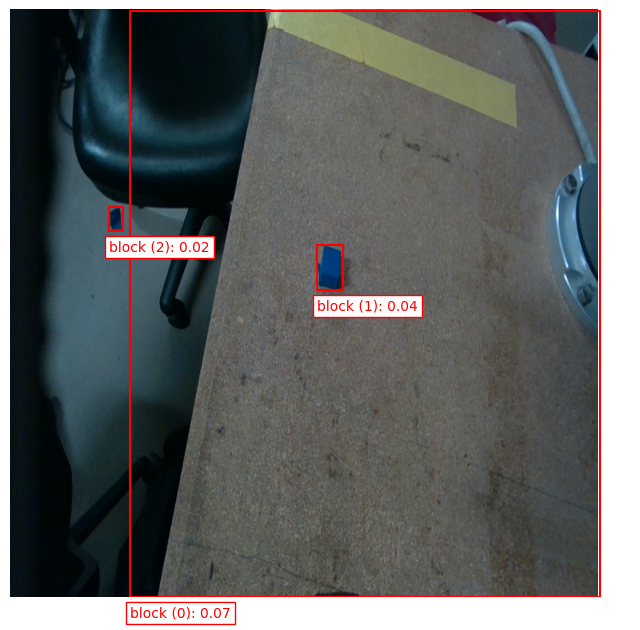

[505:543][5876] (stun_port.cc:96): Binding request timed out from 192.168.0.x:40951 (enp3s0)


In [16]:
tmats = []

In [35]:
index = 1
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd|.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd, tmat, pcaFrame = pcd.get_segment(
                                        label_vit.sorted_labeled_boxes_coords, 
                                        # label_vit.boxes, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                         type="box-dbscan", 
                                        #  type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                        #  display=False,
                                         display=True,
                                         viz_scale=1000)
tmat, tmat[:3, 3]
tmats.append(tmat)
#save cpcd in a folder using open3d
o3d.io.write_point_cloud("saved_pcd/cpcd5.ply", cpcd)


z-axis dot product: [0.708]
[Open3D INFO] Window window_8 created.


WebVisualizer(window_uid='window_8')

True

[Open3D INFO] Sending init frames to window_8.


In [38]:
#load ply file using open3d and apply transformation
for i in range(5):
    cpcd = o3d.io.read_point_cloud(f"saved_pcd/cpcd{i+1}.ply")
    cpcd.transform(tmats[i])
    o3d.io.write_point_cloud(f"transformed_pcds/cpcd{i+1}_t.ply", cpcd)


In [40]:
merged = o3d.io.read_point_cloud(f"transformed_pcds/cpcd1_t.ply")
for i in range(1,4):
    cpcd = o3d.io.read_point_cloud(f"transformed_pcds/cpcd{i+1}_t.ply")
    merged += cpcd
o3d.visualization.draw_geometries([merged])

In [ ]:
# move gripper to cartesian pos
# OR orient gripper in place
sleepRate = 1.5
# time.sleep(sleepRate)
ur = ur5.UR5_Interface()
try:
    ur.start()
    # homePose = ur.get_tcp_pose()
    homePose = ur.getPose()
    currentPose = ur.getPose()
    desiredPose = np.matmul(np.array(currentPose), tmat)
    print("Desired Pose: ", desiredPose)
    # in-place (or best attempt) re-orientation
    # ur.moveL(desiredPose)
    ## move to cartesian pos
    gt.move_to_L(grasp_pose, ur, z_offset=z_offset)    
    print("Done moving to block")
    time.sleep(sleepRate)
    time.sleep(sleepRate)
    ur.stop()
except Exception as e:
    ur.stop()
    raise(e)

In [ ]:
# move home
ur = ur5.UR5_Interface()
try:
    ur.start()
    # time.sleep(sleepRate)
    # homePose = np.array([[-0.024, -0.998, -0.062, -0.261],
    #                     [-0.999,  0.021,  0.035, -0.162],
    #                     [-0.033,  0.063, -0.997,  0.221],
    #                     [ 0.   ,  0.   ,  0.   ,  1.   ]])
    ur.moveL(homePose)
    # gt_home = ur.getPose()
    # print(np.array(gt_home))
    time.sleep(sleepRate * 3)
    ur.stop()
except Exception as e:
    ur.stop()

In [ ]:
# DO NOT EXECUTE

In [ ]:
# # orient and move gripper to cartesian pos
# sleepRate = 1.5
# ur = ur5.UR5_Interface()
# try:
#     servoPort = "/dev/ttyACM0"
#     ur.start()
#     time.sleep(sleepRate)
#     homePose = ur.get_tcp_pose()    
#     '''
#     stopping point 2/15:
#     this works so far
#     take home pos
#     add translation on the gripper frame to the goal x, y
#     apply tmat to the goal
#     move to goal (translates on x, y and orients at the same time)
#     ## does this address the fact that orientation is not achievable in standstill?

#     then: take orig Z (from original gripper frame): [0, 0, dZ]
#     transform by tmat (the current orientation of the gripper)
#     add transformed dZ to the goal position
#     move
#     works!
#     '''
#     dX,dY,dZ = gt.get_world_frame(grasp_pose, ur, z_offset=z_offset)

#     goal1 = copy.deepcopy(homePose)
#     goal1 = np.array(goal1)
#     # goal1[:3, 3] += [dX, dY, 0]
#     goal1[:3, 3] += [dX, dY, dZ]
#     goal1 = np.array(goal1) @ tmat
#     ur.moveL(goal1)
#     time.sleep(sleepRate)

#     # todo: take currentPose and validate orientation?
#     goal2 = goal1
#     posd = [0, 0, dZ] @ tmat[:3, :3]
#     goal2 = np.array(goal2)
#     goal2[:3, 3] += posd
#     # ur.moveL(goal2)
#     time.sleep(sleepRate)
#     '''
#     end of working section
#     '''
#     ur.stop()
# except Exception as e:
#     ur.stop()
#     raise(e)